In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
from tqdm import tqdm

In [2]:
def load(path, fmt):
    return SeqIO.parse(path, fmt)

def getGC(seqs):
    all_gc = dict() # gc -> count
    for line in tqdm(seqs):
        gc = 0
        good = 0
        seq = line.seq
        qual = line.letter_annotations["phred_quality"]
        for (a, b) in zip (seq, qual):
            # do not count bases with QUAL <= 10
            if b > 10:
                good += 1
                if a == 'G' or a =='C':
                    gc += 1
        if good > len(seq) * 0.5: # filter reads trimmed more than x2
            gc = round(gc * 1.0 / good, 2)
            if gc not in all_gc:
                all_gc[gc] = 0
            all_gc[gc] += 1
    
    plt.scatter(all_gc.keys(), all_gc.values())
    plt.xlim(0, 1)
    plt.show()
    
    total = 0
    mean = 0
    for (a, b) in zip(all_gc.keys(), all_gc.values()):
        total += b
        mean += a * b
    print("Mean GC =", mean * 1. / total)
    
def getBaseQual(seqs):
    l = len(next(seqs).seq)
    quals = [0 for _ in range(l)] # position -> list of quals
    total = 0
    for line in tqdm(seqs):
        qual = line.letter_annotations["phred_quality"]
        for i, q in enumerate(qual):
            quals[i] += q
        total += 1
    
    quals = np.array(quals)
    plt.figure(figsize=(15, 10))
    plt.plot(quals/total)
    plt.xticks([1] + list(range(5, l+2, 5)), [1] + list(range(5, l+2, 5)))
    plt.title("Phred quality scores distribution by bases")
    plt.show()
    plt.clf()
    
    plt.figure(figsize=(15, 10))
    plt.plot([10**(-q*1./10) for q in quals/total])
    plt.xticks([1] + list(range(5, l+2, 5)), [1] + list(range(5, l+2, 5)))
    plt.yscale('log')
    plt.title("Probability error distribution by bases")
    plt.show()

1716182it [01:39, 17199.66it/s]


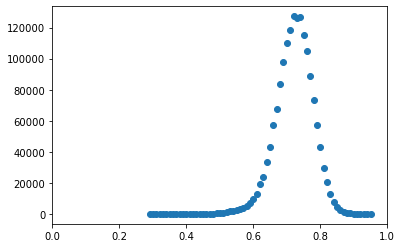

Mean GC = 0.721650749051759


In [3]:
with gzip.open("frag.R1.fastq.gz", "rt") as file:
    getGC(load(file, "fastq-illumina"))

mean GC content is about 72%, which is in agreement with FastQC results
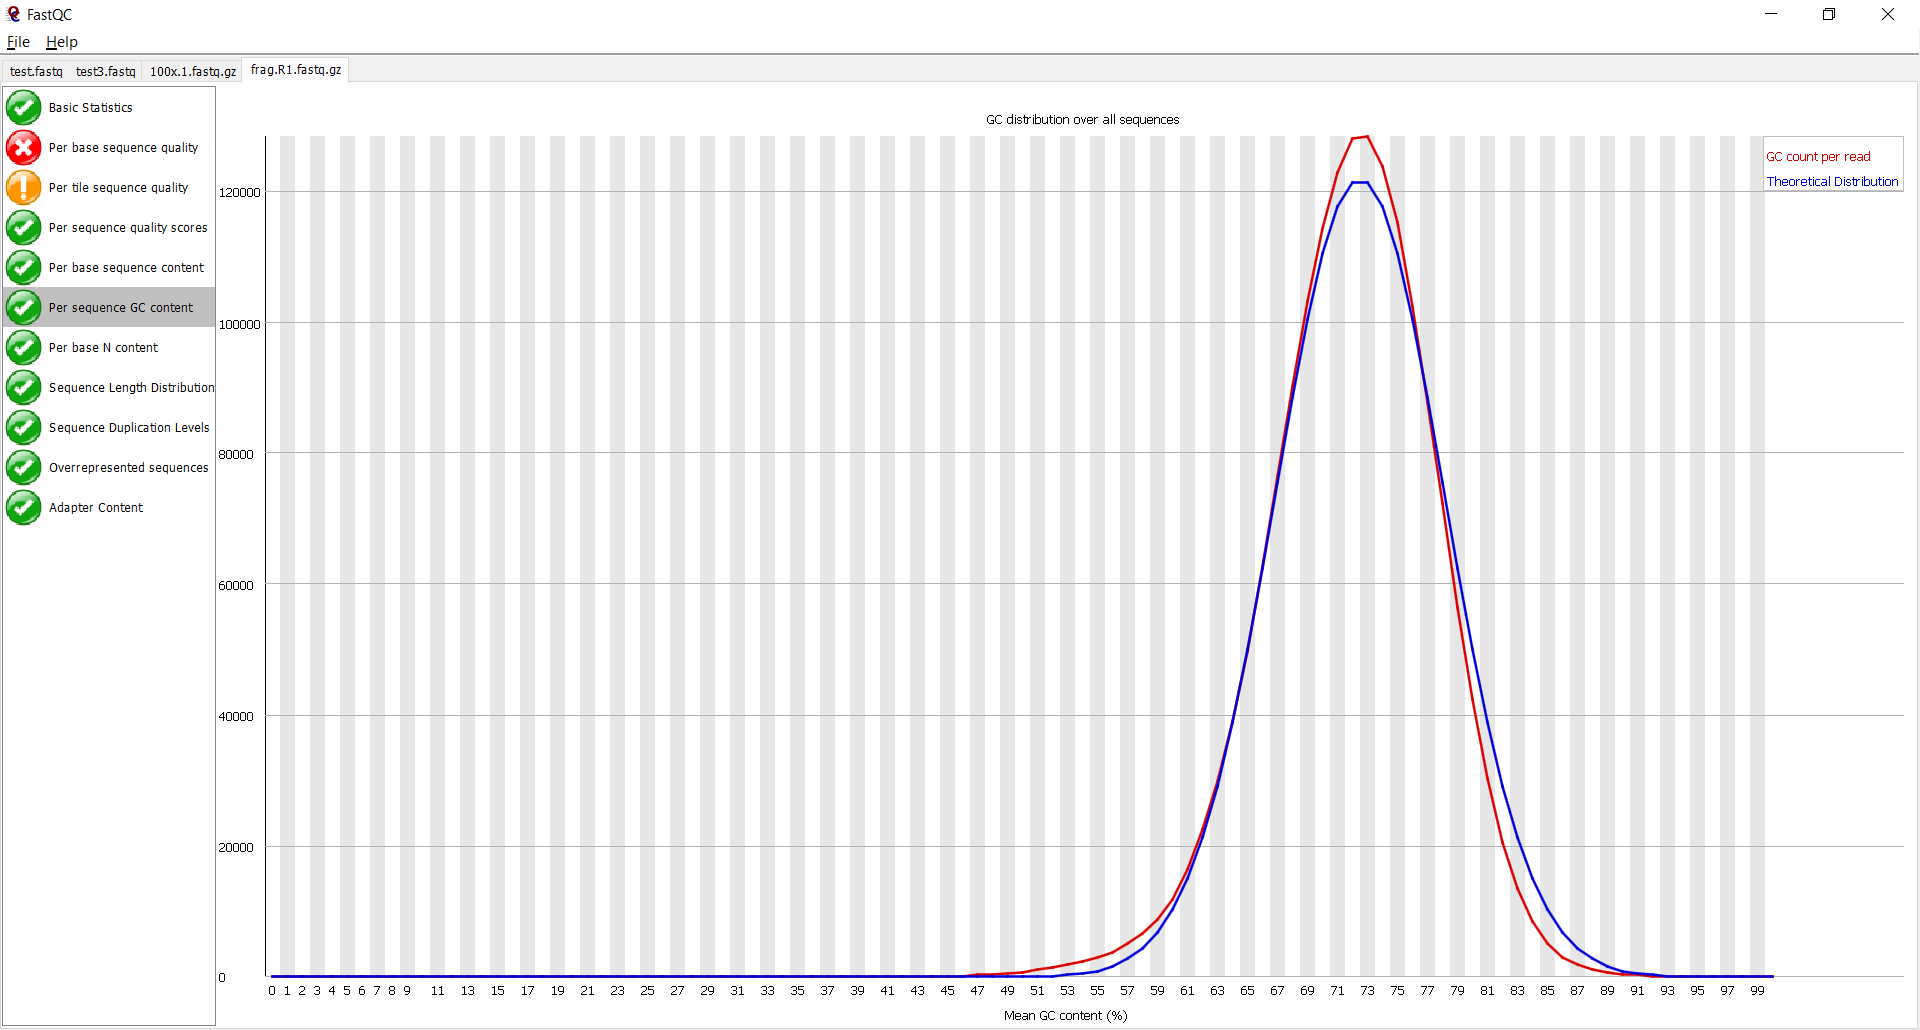

1716182it [01:35, 17957.60it/s]


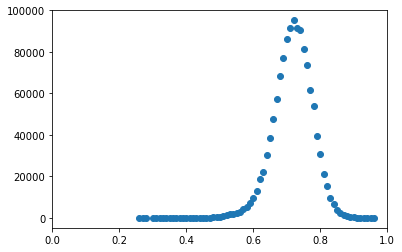

Mean GC = 0.7172258968565741


In [4]:
with gzip.open("frag.R2.fastq.gz", "rt") as file:
    getGC(load(file, "fastq-illumina"))

mean GC content is about 72%, which is in agreement with FastQC results
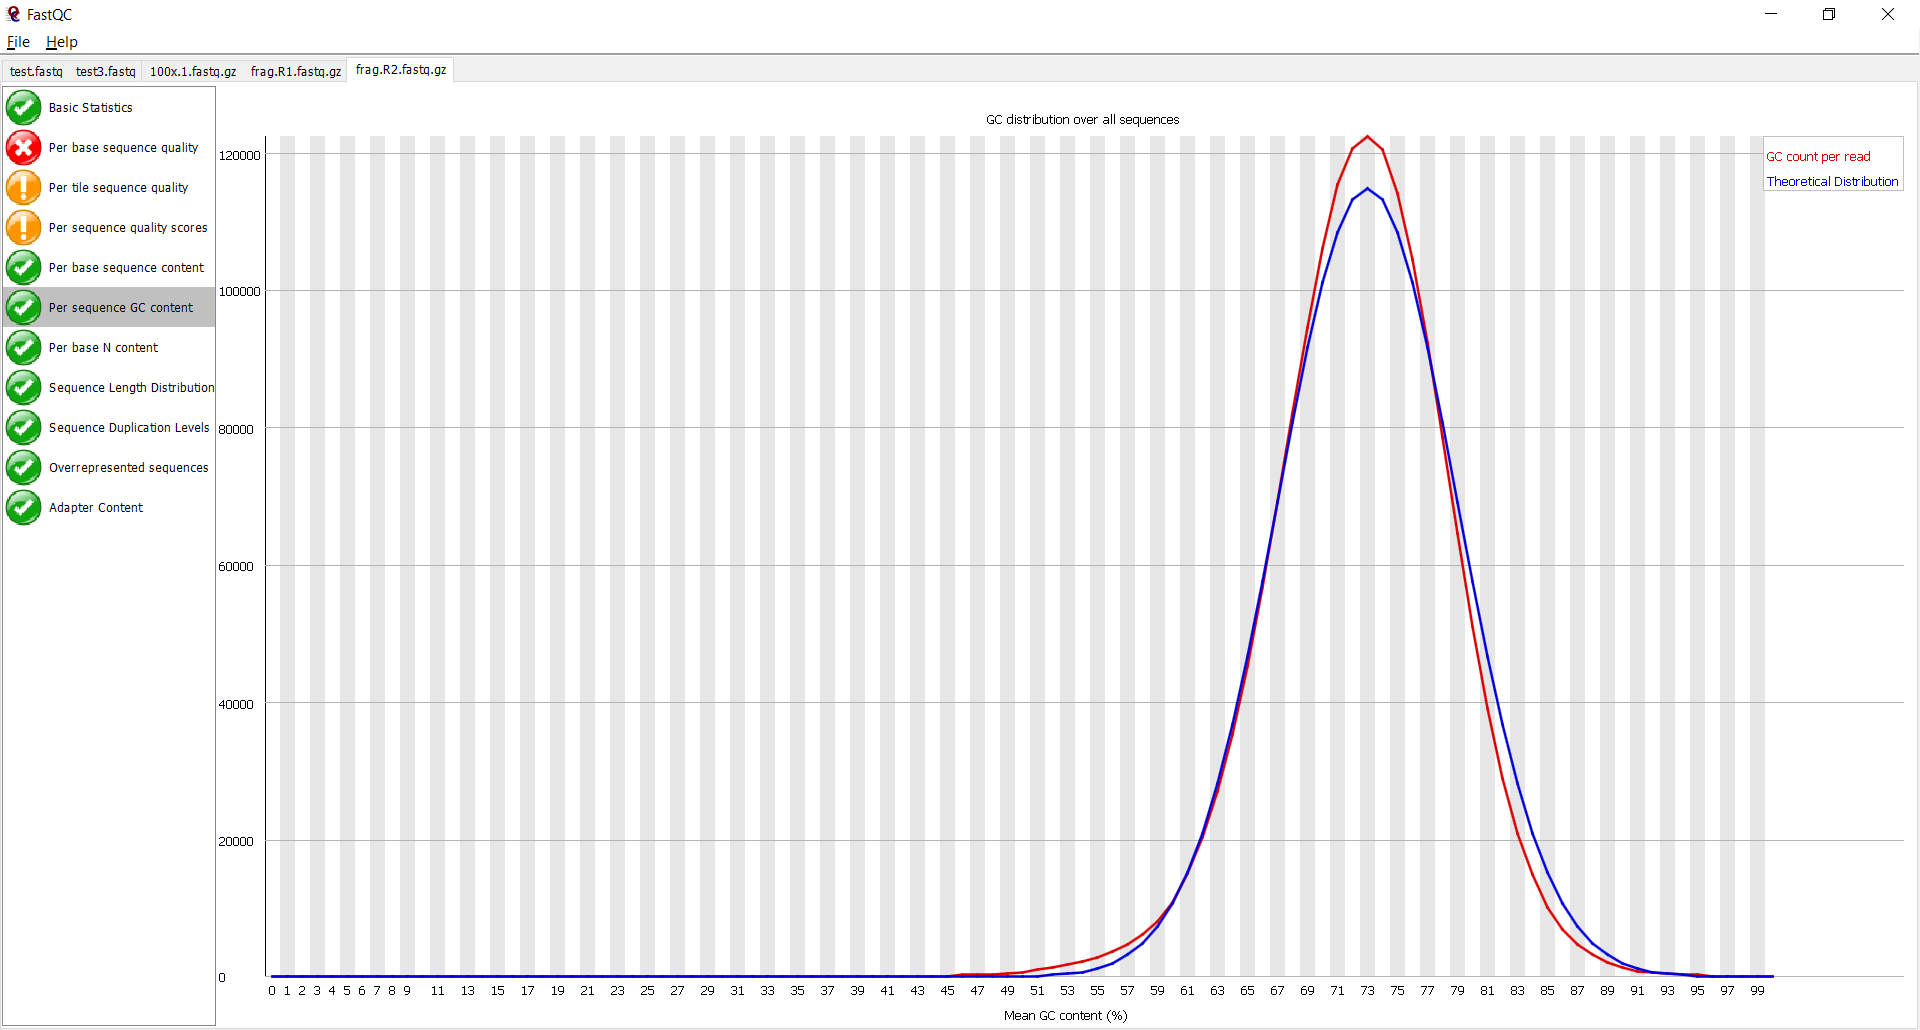

1716181it [00:54, 31483.77it/s]


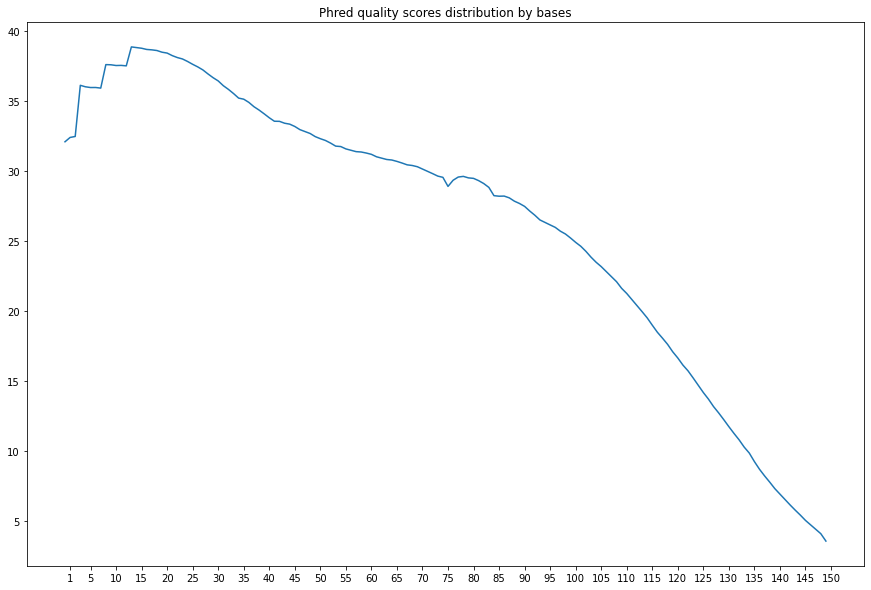

<Figure size 432x288 with 0 Axes>

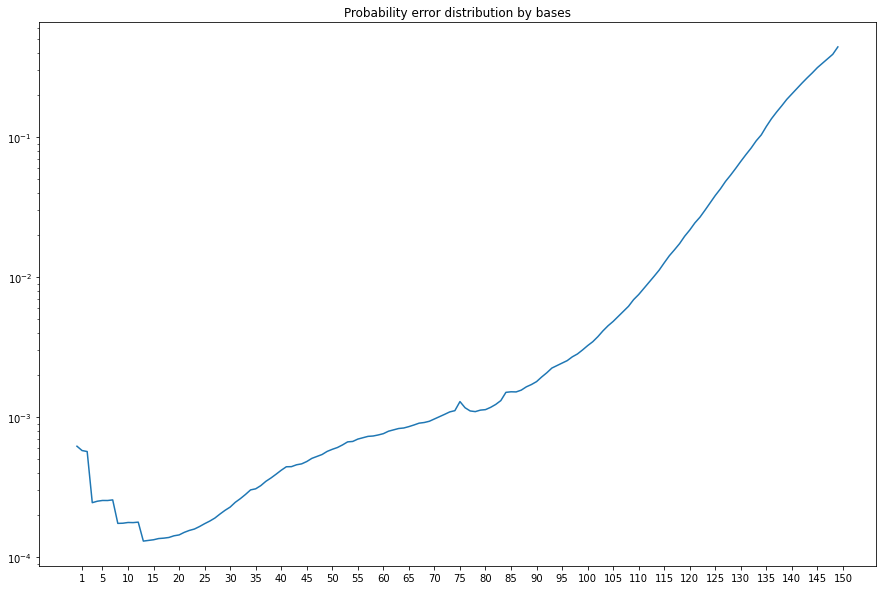

In [5]:
with gzip.open("frag.R1.fastq.gz", "rt") as file:
    getBaseQual(load(file, "fastq-illumina"))

Quality is dropping down and error probability rises to the end of the read, which is in agreement with FastQC results
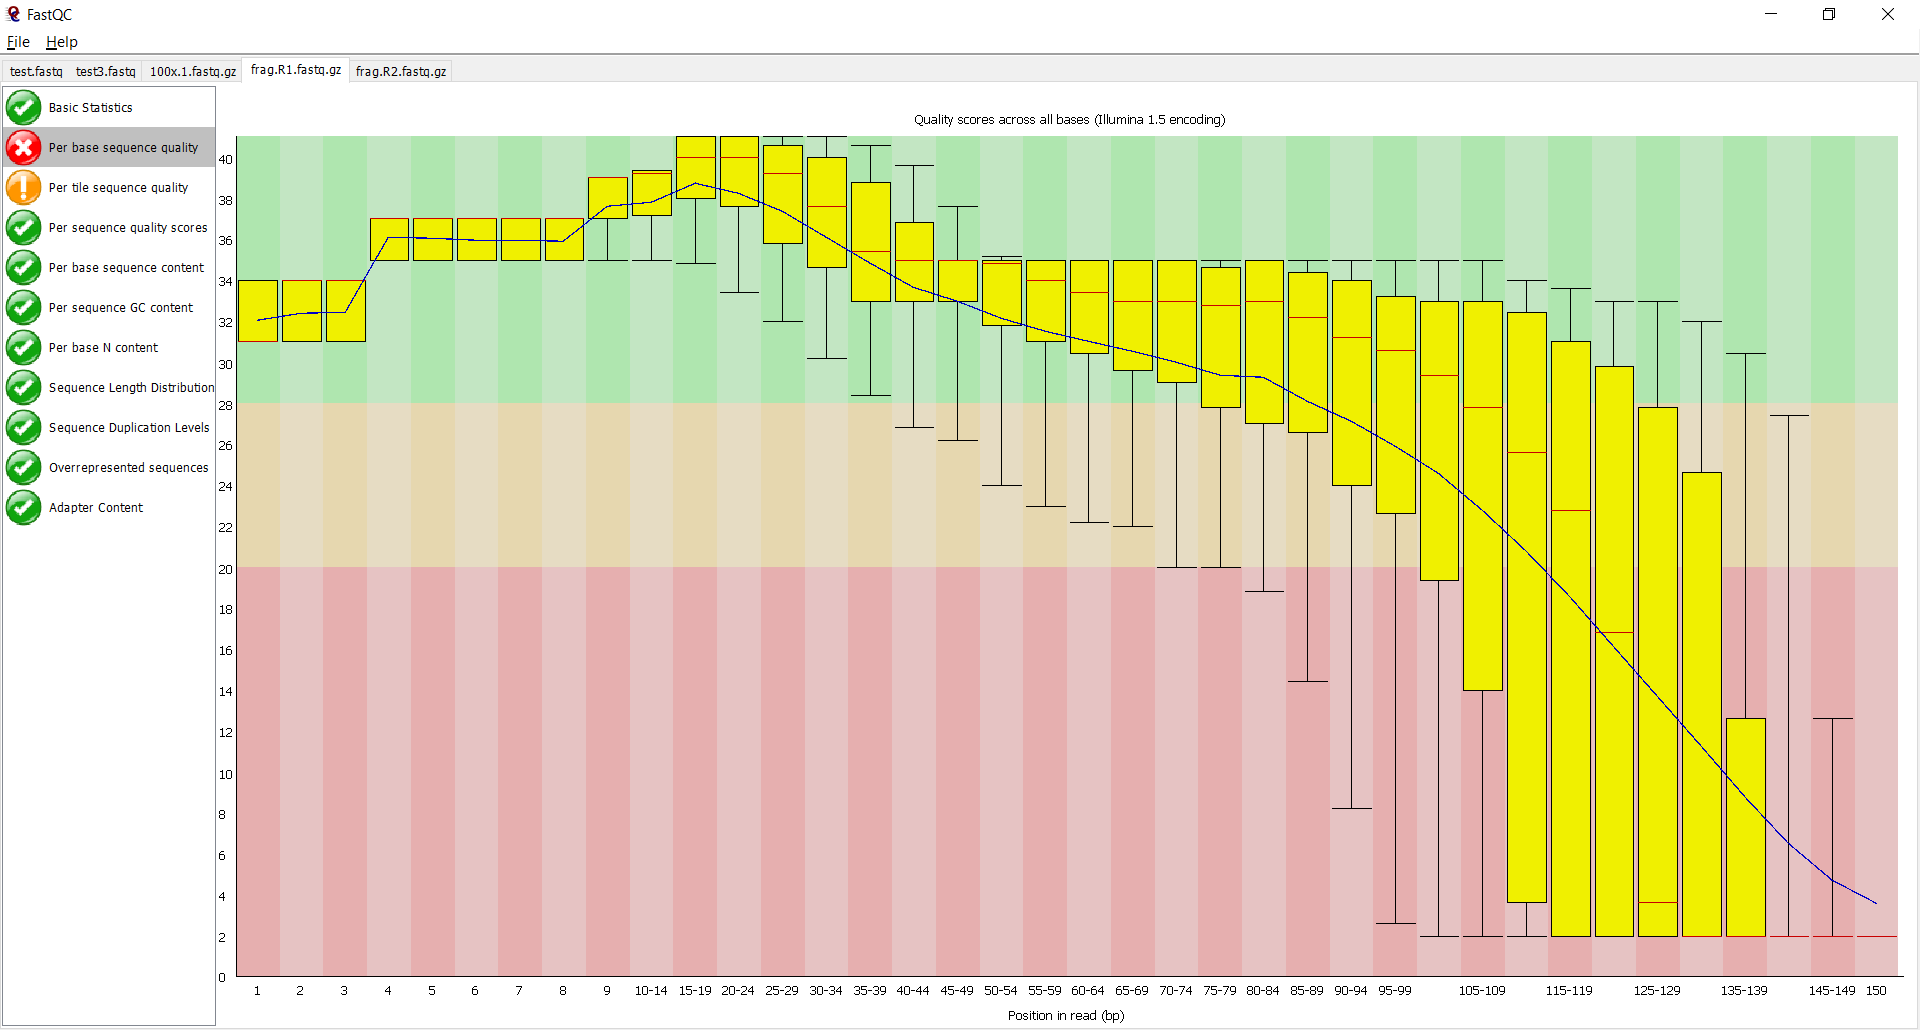

1716181it [00:55, 30974.56it/s]


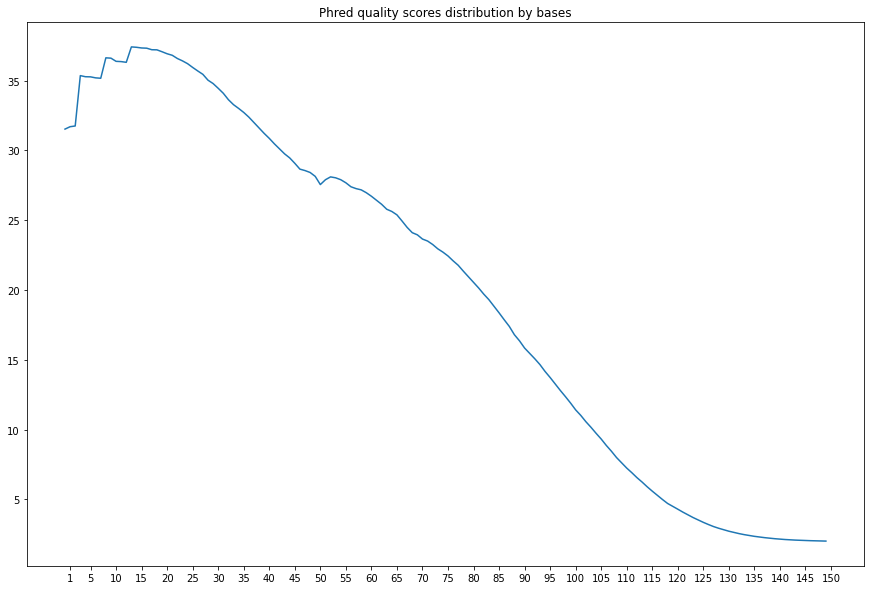

<Figure size 432x288 with 0 Axes>

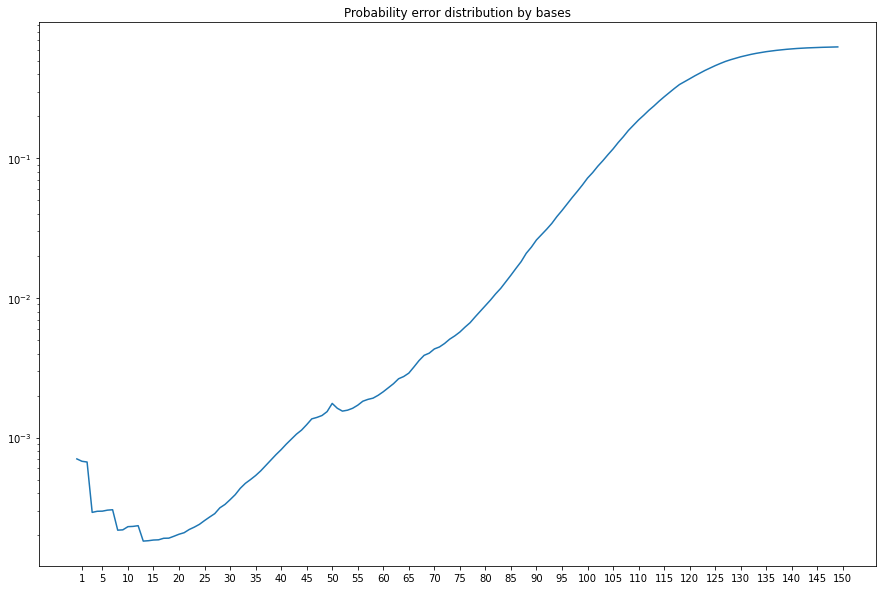

In [6]:
with gzip.open("frag.R2.fastq.gz", "rt") as file:
    getBaseQual(load(file, "fastq-illumina"))

Quality is dropping down and error probability rises to the end of the read, which is in agreement with FastQC results. Quality drops faster in the second read in paired-end reads, a known phenomena for Illumina.
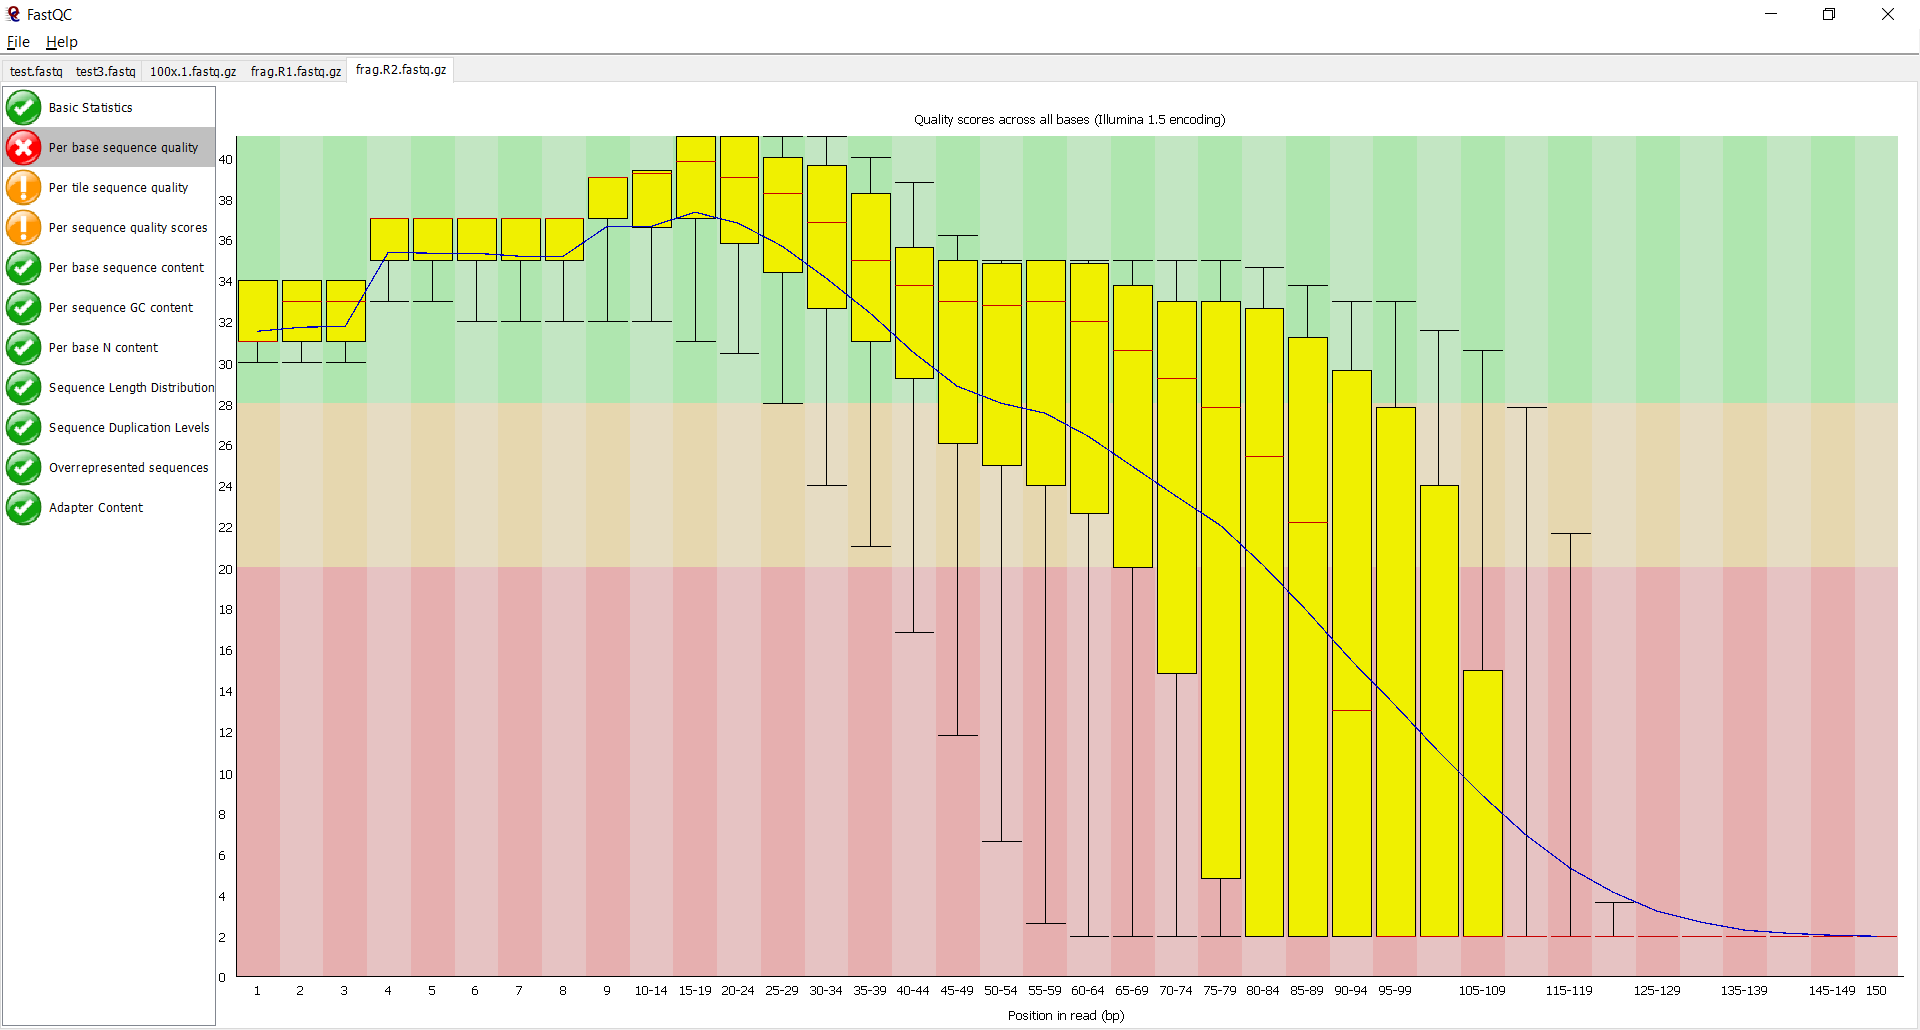